Copy of ML classification notebook with KNN architecture.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import scipy.stats
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.neighbors
import sklearn.feature_selection
import sklearn.tree
import unittest

In [2]:
cd /Users/loganroberts/Learn2Therm/ValidProt/data

/Users/loganroberts/Learn2Therm/ValidProt/data


In [3]:
#convert to pandas df
df_original = pd.read_csv('learn2therm_sample_50k/learn2therm_sample_50k.csv')

In [4]:
df_original.head()

,Unnamed: 0,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,thermo_index,...,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_seq,t_protein_seq,m_protein_desc,t_protein_desc,m_protein_len,t_protein_len
0,0,0.287582,0.217822,0.215686,160,0.792079,152,0.737864,131,875,...,1153.0,27.5,50.0,22.5,MAESGTSRRADHLVPVPGPDAEPPAVADELLRAVGRGDEQAFGRLY...,MPSQITESERIELAERFERDALPLLDQLYSAALRMTRNPADAEDLV...,ECF RNA polymerase sigma factor SigK,sigma-70 family RNA polymerase sigma factor,206,202
1,1,0.319635,0.295359,0.297872,218,0.919831,226,0.969957,282,11324,...,1014.0,25.0,54.0,29.0,MARIALVDDDRNILTSVSMTLEAEGFEVETYNDGQSALDAFNKRMP...,MRVLLVEDDPNTSRSIEMMLTHANLNVYATDMGEEGIDLAKLYDYD...,response regulator transcription factor,response regulator transcription factor,233,237
2,2,0.279621,0.234127,0.218924,211,0.837302,210,0.731707,96,875,...,1138.0,28.0,50.0,22.0,MKDTVVFVTGAARGIGAHTARLAVARGARVALVGLEPHLLADLAAE...,MTPEQIFSGQTAIVTGGASGIGAATVEHIARRGGRVFSVDLSYDSP...,SDR family oxidoreductase,SDR family oxidoreductase,287,252
3,3,0.327273,0.200743,0.214712,166,0.617100,163,0.696581,175,875,...,1077.0,28.0,50.0,22.0,MTSGLWERVLDGVWVTIQLLVLSALLATAVSFVVGIARTHRLWIVR...,MAMSRRKRGQLARGIQYAILVIVVVVLALLADWGKIGKAFFDWEAA...,ectoine/hydroxyectoine ABC transporter permeas...,amino acid ABC transporter permease,234,269
4,4,0.338710,0.318182,0.287671,60,0.909091,71,0.887500,61,9827,...,991.0,30.0,50.0,20.0,MIISLRRGLRFIRFIVFFAALVYLFYHVLDLFNGWISPVDQYQMPT...,MKRMVWRTLKVFIIFIACTLLFYFGLRFMHLEYEQFHRYEPPEGPA...,YqzK family protein,YqzK family protein,80,66


In [5]:
#isolate the categories that appear more than 500 times

categories = df_original['t_protein_desc'].value_counts()
categories = categories.iloc[categories.values > 500]
categories_dict = {item: None for item in categories.index}

list_of_cats = list(categories_dict.keys())
list_of_cats

['ABC transporter ATP-binding protein',
 'SDR family oxidoreductase',
 'ATP-binding cassette domain-containing protein',
 'response regulator transcription factor',
 'ABC transporter permease',
 'TetR/AcrR family transcriptional regulator',
 'carbohydrate ABC transporter permease',
 'sugar ABC transporter permease',
 'hypothetical protein',
 'SDR family NAD(P)-dependent oxidoreductase',
 'response regulator']

In [6]:
df = df_original[df_original.t_protein_desc.isin(list_of_cats)]
df.shape

(23783, 30)

In [7]:
#create new "dummy" target feature 

df['protein_match'] = df['t_protein_desc'].eq(df['m_protein_desc'])
df['protein_match'].head()

/var/folders/1n/stf1qksj3jb8f79pgwq8cslc0000gn/T/ipykernel_1368/1069402308.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['protein_match'] = df['t_protein_desc'].eq(df['m_protein_desc'])


1      True
2      True
5      True
9     False
12    False
Name: protein_match, dtype: bool

In [8]:
df['protein_match'].value_counts()

True     13099
False    10684
Name: protein_match, dtype: int64

In [9]:
#get rid of stuff that isn't quantitative

df = df.drop(columns = ['Unnamed: 0','thermo_index', 'm_protein_seq', 't_protein_seq',
                        'm_protein_desc', 't_protein_desc'])

In [10]:
df.head()

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,meso_index,prot_pair_index,...,scaled_local_symmetric_percent_id_16s,query_align_cov_16s,subject_align_cov_16s,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_len,t_protein_len,protein_match
1,0.319635,0.295359,0.297872,218,0.919831,226,0.969957,282,13026,92992745,...,0.902522,1.000000,1.000000,1014.0,25.0,54.0,29.0,233,237,True
2,0.279621,0.234127,0.218924,211,0.837302,210,0.731707,96,8203,157628663,...,0.923531,1.000000,1.000000,1138.0,28.0,50.0,22.0,287,252,True
5,0.333333,0.267380,0.254453,148,0.791444,163,0.791262,127,3582,20752996,...,0.880157,0.997391,0.997370,942.0,17.5,42.0,24.5,206,187,True
9,0.333333,0.295082,0.291498,218,0.893443,221,0.884000,158,742,85102366,...,0.910105,0.998040,0.998022,1085.0,26.0,50.0,24.0,250,244,False
12,0.354067,0.245847,0.225954,208,0.691030,216,0.610170,264,13575,55279368,...,0.912500,0.996721,0.996700,1095.0,28.0,52.5,24.5,354,301,False


From pairplot below, it looks like query_align_cov_16s and subject_align_cov_16s dont correlate with target. Let's remove them.

In [11]:
# sns.pairplot(df.sample(500),height = 4)

In [12]:
df = df.drop(columns = ['query_align_cov_16s', 'subject_align_cov_16s'])

In [13]:
df.describe()

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,meso_index,prot_pair_index,...,taxa_pair_index,local_gap_compressed_percent_id_16s,scaled_local_query_percent_id_16s,scaled_local_symmetric_percent_id_16s,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_len,t_protein_len
count,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,2.378300e+04,...,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000,23783.000000
mean,0.330515,0.255968,0.251793,206.720725,0.781491,206.319304,0.770447,209.895766,8057.971745,9.088823e+07,...,363429.641887,0.906876,0.903185,0.905010,1061.304503,27.371715,51.477799,24.106084,271.792961,267.108397
std,0.060568,0.075837,0.075889,45.130804,0.135684,45.314127,0.162151,115.963286,4602.593029,5.206080e+07,...,226799.643391,0.015064,0.015445,0.015098,74.656304,3.617415,3.577307,3.509046,48.848302,52.720419
min,0.179012,0.100817,0.059908,25.000000,0.481482,25.000000,0.082019,36.000000,5.000000,1.219000e+03,...,4885.000000,0.876590,0.836055,0.880026,891.000000,7.000000,41.000000,20.000000,52.000000,33.000000
25%,0.293333,0.205432,0.205288,188.000000,0.675035,188.000000,0.664506,135.000000,4081.000000,4.647432e+07,...,174094.000000,0.896178,0.893115,0.893770,1011.000000,27.500000,50.000000,22.000000,240.000000,237.000000
50%,0.321429,0.243590,0.239845,211.000000,0.786325,211.000000,0.791506,193.000000,7997.000000,9.155334e+07,...,312334.000000,0.906122,0.902487,0.903840,1057.000000,28.000000,52.500000,24.500000,263.000000,261.000000
75%,0.354665,0.290566,0.283247,232.000000,0.902174,230.000000,0.905455,253.000000,12100.000000,1.353189e+08,...,617843.000000,0.916392,0.912787,0.914921,1108.000000,29.000000,52.500000,24.500000,305.000000,305.000000
max,0.923077,0.914798,0.916854,388.000000,1.000000,388.000000,1.000000,1359.000000,16345.000000,1.814861e+08,...,744518.000000,0.999351,0.993544,0.996439,1618.000000,40.000000,78.000000,56.000000,400.000000,400.000000


Split dev and test data:

In [14]:
#drop columns that don't exihibit signficant pearson correlation with bit_score

df = df.drop(columns = ['meso_index', 'meso_protein_int_index', 'local_gap_compressed_percent_id_16s', 
                        'scaled_local_query_percent_id_16s', 'scaled_local_symmetric_percent_id_16s',
                       'bit_score_16s', 'm_ogt', 't_ogt', 'taxa_pair_index', 'thermo_protein_int_index'
                       , 'prot_pair_index', 'ogt_difference'])

In [15]:
#choosing 80/20 split instead of 85/15 because of volume of data

dev, test = sklearn.model_selection.train_test_split(df, test_size=0.15, random_state=1)

train, val = sklearn.model_selection.train_test_split(dev, test_size=0.15, random_state=1)

print(dev.shape)
print(test.shape)
print(train.shape)
print(val.shape)

(20215, 11)
(3568, 11)
(17182, 11)
(3033, 11)


In [16]:
#ID target and features, separate into separate arrays

target = 'protein_match'
input_features = [columns for columns in df]
input_features.remove(target)

In [17]:
print(input_features)
print(target)

['local_gap_compressed_percent_id', 'scaled_local_query_percent_id', 'scaled_local_symmetric_percent_id', 'query_align_len', 'query_align_cov', 'subject_align_len', 'subject_align_cov', 'bit_score', 'm_protein_len', 't_protein_len']
protein_match


In [18]:
#split X and y

dev_X = dev[input_features].values
test_X = test[input_features].values

dev_y = dev[target].values.reshape(-1,1)
test_y = test[target].values.reshape(-1,1)  

print(dev_X.shape, test_X.shape, dev_y.shape, test_y.shape)

(20215, 10) (3568, 10) (20215, 1) (3568, 1)


In [19]:
#same thing for training and validation data

train_X = train[input_features].values
val_X = val[input_features].values

train_y = train[target].values.reshape(-1,1)
val_y = val[target].values.reshape(-1,1) 

Scale the data

In [20]:
scaler = sklearn.preprocessing.StandardScaler()
dev_X = scaler.fit_transform(dev_X)
test_X = scaler.fit_transform(test_X)
train_X = scaler.fit_transform(train_X)
val_X = scaler.fit_transform(val_X)

Train the model

In [21]:
#KNN gives a better fit

model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=20)
model.fit(dev_X, dev_y.ravel())

KNeighborsClassifier(n_neighbors=20)

Test the model, report relevant statistics

In [22]:
score = model.score(test_X, test_y)
print('Model score is: {}'.format(score))

preds = model.predict(test_X)
print(preds)

Model score is: 0.632847533632287
[False  True  True ... False False  True]


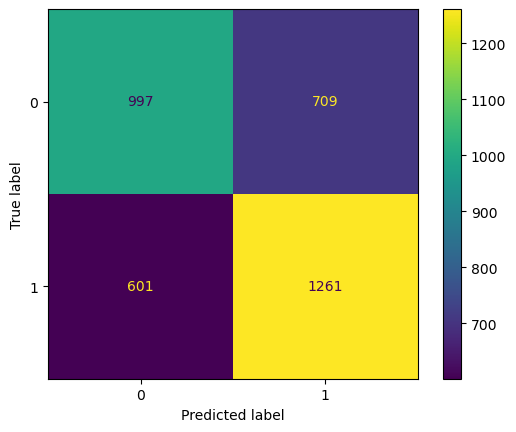

In [23]:
#confusion matrix

confusion_matrix = sklearn.metrics.confusion_matrix(preds, test_y)
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix).plot()

Convert the above code into functions.

In [24]:
def train_model(dataframe, columns = [],  target = []):
    """
    Takes dataframe and splits it into a training and testing set. 
    Note: Data is called train and test, but this test set is currently
    closer to a validation set. Keeping nomenclature to keep model robust.
    Trains a KNN classifier model with selected data.
    
    Params
    ----------
    dataframe: Pandas dataframe 
    columns: list of strings, representing input features
    target: list of strings, representing target feature(s)

    Returns
    -------
    -Sk-learn model object
    -train data (features)
    -train data (target)
    -validation data (features)
    -validation data (target)
    """
    #split data
    dev, test = sklearn.model_selection.train_test_split(dataframe, test_size=0.15, random_state=1)
    
    #test input arguments
    assert "pandas.core.frame.DataFrame" in str(type(dev))
    assert "pandas.core.frame.DataFrame" in str(type(test))
    assert "str" in str(type(columns[0]))
    assert "str" in str(type(target[0]))
   
    #split into input and output feature(s)
    dev_X = dev[columns].values
    test_X = test[columns].values

    dev_y = dev[target].values.reshape(-1,1)
    test_y = test[target].values.reshape(-1,1)
    
    #scale data
    scaler = sklearn.preprocessing.StandardScaler()
    dev_X = scaler.fit_transform(dev_X)
    test_X = scaler.fit_transform(test_X)
    
    #train model
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=20)
    model = model.fit(dev_X, dev_y.ravel())
    
    return model, dev_X, dev_y, test_X, test_y
    

In [25]:
# model, dev_X, dev_y, test_X, test_y = train_model(df, columns = input_features, 
#                                           target='protein_match')

In [26]:
class TestModelTraining(unittest.TestCase):
    
    def test_invalid_inputs(self):
    
        #test that input data type is correct
        
        try:
            train_model([1,2,3], columns = 'string', target = 'string')
            self.assertTrue(False)
        except AssertionError:
            self.assertTrue(True)
        
    def test_output_format(self):
        
        #asserts that function returns 4 objects to be assigned to pearson_corr, model, test_X, test_y
        assert len(train_model(df, columns = input_features, 
                                          target = target)) == 5
        

suite = unittest.TestLoader().loadTestsFromTestCase(TestModelTraining)
_ = unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 0.025s

OK


Write an accuracy test. Maybe move the pearson correlation to a unit test to ensure that all variables are valuable to the model.

In [27]:
#need to fix this

def evaluate_model(model, test_X, test_y):
    
    """
    Takes a trained model and test data and tests the model.
    
    Params
    ----------
    model: sklearn.neighbors.KNeighborsClassifier
    test_X: numpy array
    test_y: numpy array

    Returns
    -------
    Vector of predictions based on the model (numpy array)
    """
    
    #test input arguments
    assert "sklearn" in str(type(model))
    assert "numpy.ndarray" in str(type(test_X))
    assert "numpy.ndarray" in str(type(test_y))
    
    preds = model.predict(test_X)
    
    return preds

In [28]:
preds = evaluate_model(model, test_X, test_y)
preds

array([False,  True,  True, ..., False, False,  True])

In [29]:
class TestModelPerformance(unittest.TestCase):

    def test_asserts(self):
        model, dev_X, dev_y, test_X, test_y = train_model(
            df, columns=input_features, target='protein_match'
        )
        # assert that input types are correct
        with self.assertRaises(AssertionError):
            evaluate_model(model, [1, 2, 3], test_y)
            
    def test_model_output(self):
        model, dev_X, dev_y, test_X, test_y = train_model(
            df, columns=input_features, target='protein_match'
        )
        # assert output type is correct
        output = evaluate_model(model, test_X, test_y)
        self.assertIsInstance(output, np.ndarray)
        
    def test_pred_dimension(self):
        model, dev_X, dev_y, test_X, test_y = train_model(df, 
            columns=input_features, target='protein_match'
        )
        # want to check that the number of predictions is equal to the number of test examples
        preds = evaluate_model(model, test_X, test_y)
        self.assertEqual(len(test_y), len(preds))

suite = unittest.TestLoader().loadTestsFromTestCase(TestModelPerformance)
_ = unittest.TextTestRunner().run(suite)


...
----------------------------------------------------------------------
Ran 3 tests in 0.588s

OK


A good test here can be adding outliers and seeing how much the score and predictions change (probably for the above function).

In [30]:
def plot_model(model, test_X, test_y):
    """
    Takes a test KNN Classifier model and plots the confusion matrix.
    
    Params
    ----------
    model: sklearn.neighbors.KNeighborsClassifier
    test_X: numpy array
    test_y: numpy array

    Returns
    -------
    -Confusion predictions vs. observations
    -Model score
    """
    
    #test input arguments
    assert "sklearn" in str(type(model))
    assert "numpy.ndarray" in str(type(test_X))
    assert "numpy.ndarray" in str(type(test_y))
    
    score = model.score(test_X, test_y)
    preds = evaluate_model(model, test_X, test_y)
   
    # plot confusion matrix
    confusion_matrix = sklearn.metrics.confusion_matrix(preds, test_y)
    cm_plot = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix)
    
    cm_plot.plot(cmap=plt.cm.Blues)
    cm_plot.ax_.set_title('Confusion Matrix')
    
    return score
    

0.632847533632287

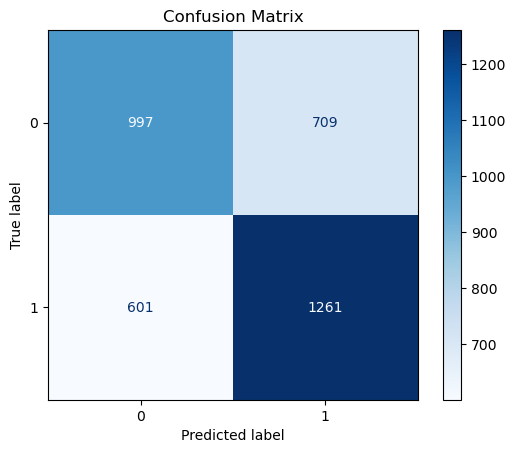

In [31]:
#make some appropriate display labels here

plot_model(model, test_X, test_y)

In [32]:
#wrapper function

def kNN_wrapper(dataframe):
    """
    Takes dataframe and runs it through kNN model.
    
    Params
    ----------
    dataframe: Pandas dataframe 

    Returns
    -------
    -Target feature predictions
    -Parity plot
    """
    
    assert 'pandas.core.frame.DataFrame' in str(type(dataframe))

    #user inputs target feature
    target = 'protein_match'
    
    #define input features
    input_features = [columns for columns in dataframe]
    
    input_features.remove(target)

    #train the model based off data split
    model, dev_X, dev_y, test_X, test_y = train_model(
                                        dataframe, columns=input_features, 
                                        target=target
                                                   )
    
    #test the model and return predictions
    preds = evaluate_model(model, test_X, test_y)
    
    #plot the results of the model
    plot_model(model, test_X, test_y)
    
    return preds

array([False,  True,  True, ..., False, False,  True])

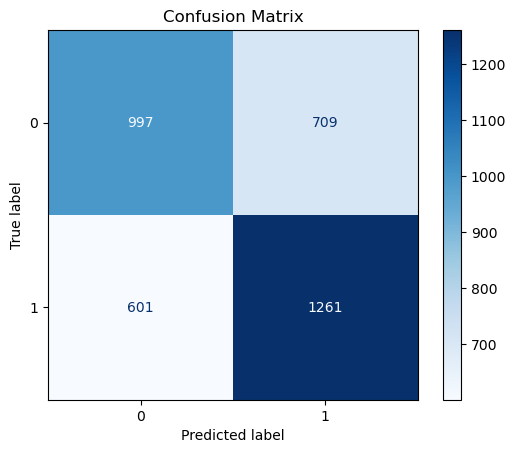

In [33]:
kNN_wrapper(df)

In [34]:
class TestWrapper(unittest.TestCase):
    
    def test_wrapper_input(self):
        #test that input data type is correct
        try:
            kNN_wrapper([1,2,3])
            self.assertTrue(False)
        except AssertionError:
            self.assertTrue(True)

    def test_wrapper_output(self):
        model, dev_X, dev_y, test_X, test_y = train_model(
            df, 
            columns=input_features, target='protein_match'
        )
        # assert output type is correct
        output = evaluate_model(model, test_X, test_y)
        self.assertIsInstance(output, np.ndarray)
        
    def test_output_dimension(self):
        model, dev_X, dev_y, test_X, test_y = train_model(
            df, 
            columns=input_features, target='protein_match'
        )
        # want to check that the number of predictions is equal to the number of test examples
        preds = evaluate_model(model, test_X, test_y)
        self.assertEqual(len(test_y), len(preds))
        

suite = unittest.TestLoader().loadTestsFromTestCase(TestWrapper)
_ = unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 0.604s

OK


**IGNORE BELOW**